In [16]:
%matplotlib inline

Traceback (most recent call last):
  File "c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\__init__.py", line 215, in process
    func(*args, **kwargs)
  File "c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\matplotlib\backends\backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\matplotlib\_pylab_helpers.py", line 54, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list


In [4]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
 
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import pandas as pd
# Import the backtrader platform
import backtrader as bt
 
# Create a Stratey
class TestStrategy(bt.Strategy):
 
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
 
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # To keep track of pending orders
        self.order = None
 
    def notify(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
 
        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
 
            self.bar_executed = len(self)
 
        # Write down: no pending order
        self.order = None
 
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
 
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
 
        # Check if we are in the market
        if not self.position:
 
            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                # current close less than previous close
 
                if self.dataclose[-1] < self.dataclose[-2]:
                    # previous close less than the previous close
 
                    # BUY, BUY, BUY!!! (with default parameters)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
 
                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()
 
        else:
 
            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
 
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
 

In [11]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

# Create a Data Feed
# 本地数据，笔者用Wind获取的东风汽车数据以csv形式存储在本地。
# parase_dates = True是为了读取csv为dataframe的时候能够自动识别datetime格式的字符串，big作为index
# 注意，这里最后的pandas要符合backtrader的要求的格式
dataframe = pd.read_csv('dfqc.csv', index_col=0, parse_dates=True)
dataframe['openinterest'] = 0
data = bt.feeds.PandasData(dataname=dataframe,
                    fromdate = datetime.datetime(2015, 1, 1),
                    todate = datetime.datetime(2016, 12, 31)
                    )
# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2015-01-05, Close, 2.62
2015-01-06, Close, 2.59
2015-01-07, Close, 2.59
2015-01-07, BUY CREATE, 2.59
2015-01-08, BUY EXECUTED, 2.60
2015-01-08, Close, 2.52
2015-01-09, Close, 2.52
2015-01-12, Close, 2.50
2015-01-13, Close, 2.48
2015-01-14, Close, 2.49
2015-01-15, Close, 2.59
2015-01-15, SELL CREATE, 2.59
2015-01-16, SELL EXECUTED, 2.60
2015-01-16, Close, 2.60
2015-01-19, Close, 2.34
2015-01-20, Close, 2.36
2015-01-21, Close, 2.50
2015-01-22, Close, 2.50
2015-01-23, Close, 2.52
2015-01-26, Close, 2.52
2015-01-27, Close, 2.48
2015-01-27, BUY CREATE, 2.48
2015-01-28, BUY EXECUTED, 2.45
2015-01-28, Close, 2.44
2015-01-29, Close, 2.40
2015-01-30, Close, 2.37
2015-02-02, Close, 2.30
2015-02-03, Close, 2.37
2015-02-04, Close, 2.33
2015-02-04, SELL CREATE, 2.33
2015-02-05, SELL EXECUTED, 2.42
2015-02-05, Close, 2.32
2015-02-05, BUY CREATE, 2.32
2015-02-06, BUY EXECUTED, 2.31
2015-02-06, Close, 2.29
2015-02-09, Close, 2.33
2015-02-10, Close, 2.37
2015-02-11, 

<IPython.core.display.Javascript object>


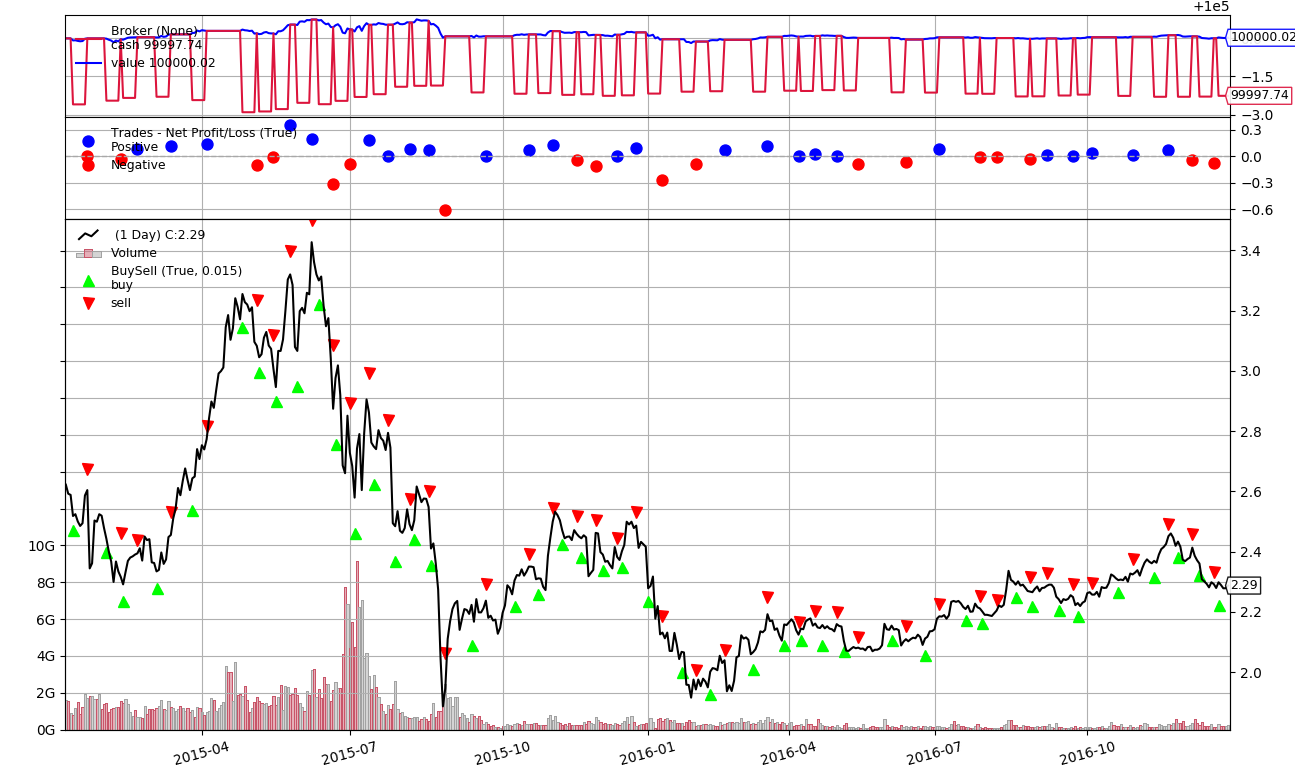

In [17]:
# Plot the result
test = cerebro.plot()

In [14]:
test

[[<Figure size 880x660 with 4 Axes>]]